In [76]:
import os, sys
import pickle
sys.path.append("../")

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from tqdm import *

from grf.grf import TransitionProbabilities, PerturbedProbability, FIRAS
from grf.units import *
from grf.pk_interp import PowerSpectrumGridInterpolator

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


# Loading $dP/dz$

Load Misha pdf from Hongwan.

In [78]:
log_analytic_pdf_interp = pickle.load(open('../data/analytic_pdf_grids/log_analytic_pdf_interp.npy', 'rb'))

Load power spectrum. Argument can be one of `["nonlin_matter", "lin_matter", "lin_baryon", "franken_upper", "franken_lower"]`.

In [79]:
pspec_nonlin_matter = PowerSpectrumGridInterpolator("nonlin_matter")

Load FIRAS class instance with that power spectrum.

In [80]:
firas = FIRAS(pspec_nonlin_matter)

../grf/grf.py:512: FutureWarning: read_table is deprecated, use read_csv instead.


Plot different PDFs. 

Argument to `firas._dP_dz` is `z_ary`, dark photon mass in natural units,  `k_min`, `k_max`, frequency array in natural units, `pdf` argument.

`pdf` argument can be in `["gaussian", "lognormal"]` or a log-pdf interpolation with class `RegularGridInterpolator`.

Output is array of shape `(2, n_freq, n_redshifts)` where first argument indexes $dP/dz$ (zero index) and $\sigma^2$ (second index).

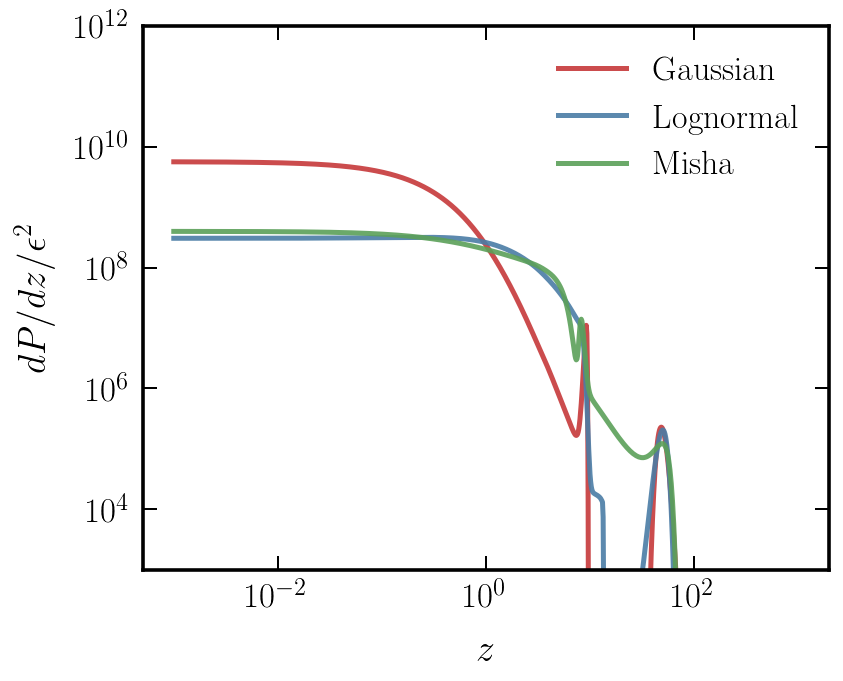

In [81]:
z_ary = np.logspace(-3, 3, 1000)
plt.plot(z_ary, firas._dP_dz(z_ary=z_ary, m_Ap=1e-13 * eV, k_min=1e-3, k_max=1e3, omega=firas.omega_FIRAS[0], pdf='gaussian')[0][0], label="Gaussian")
plt.plot(z_ary, firas._dP_dz(z_ary=z_ary, m_Ap=1e-13 * eV, k_min=1e-3, k_max=1e3, omega=firas.omega_FIRAS[0], pdf='lognormal')[0][0], label="Lognormal")
plt.plot(z_ary, firas._dP_dz(z_ary=z_ary, m_Ap=1e-13 * eV, k_min=1e-3, k_max=1e3, omega=firas.omega_FIRAS[0], pdf=log_analytic_pdf_interp)[0][0], label="Misha")

plt.xscale("log")
plt.yscale("log")

plt.ylim(1e3, 1e12)

plt.xlabel("$z$")
plt.ylabel(r"$dP/dz/\epsilon^2$")

plt.legend()

## Try varying over Frankens for LN and Gaussian

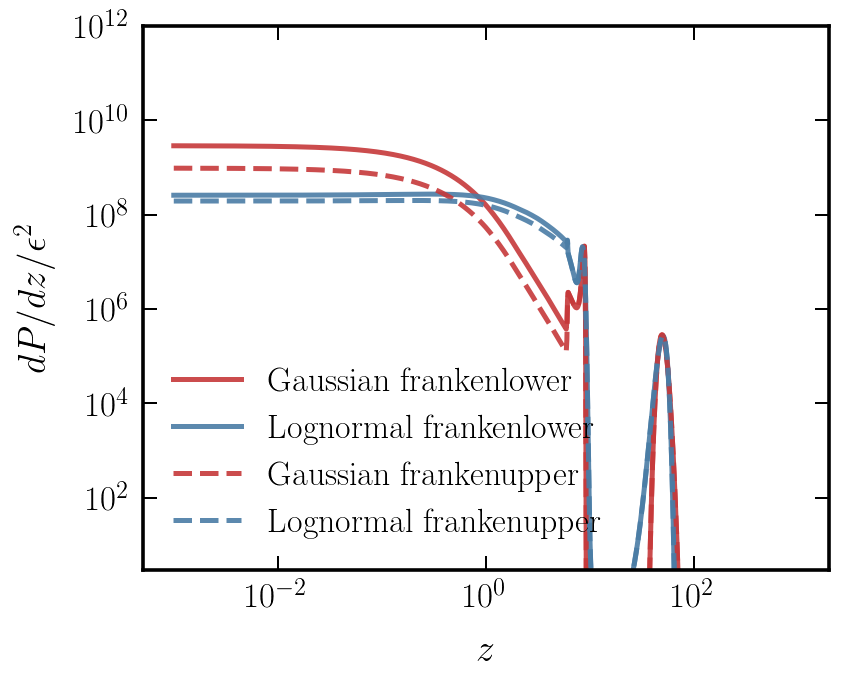

In [82]:
ls_ary = ['-', '--']

for i_p, pspec_key in enumerate(['franken_lower', 'franken_upper']):
    pspec = PowerSpectrumGridInterpolator(pspec_key)

    firas = FIRAS(pspec)
    
    z_ary = np.logspace(-3, 3, 1000)
    plt.plot(z_ary, firas._dP_dz(z_ary, 1e-13 * eV, 1e-3, 1e3, firas.omega_FIRAS[0], pdf='gaussian')[0][0], label="Gaussian " + pspec_key.replace('_',''), color=cols_default[0], ls=ls_ary[i_p])
    plt.plot(z_ary, firas._dP_dz(z_ary, 1e-13 * eV, 1e-3, 1e3, firas.omega_FIRAS[0], pdf='lognormal')[0][0], label="Lognormal " + pspec_key.replace('_',''), color=cols_default[1], ls=ls_ary[i_p])

plt.xscale("log")
plt.yscale("log")

plt.ylim(3, 1e12)

plt.xlabel("$z$")
plt.ylabel(r"$dP/dz/\epsilon^2$")

plt.legend()